### Логистическая регресcия над градиентным бустингом с AdaBoost loss

#### Decision tree regressor

In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm, trange
import copy
from sklearn.tree import DecisionTreeRegressor

from joblib import Parallel, delayed

In [2]:
EPSILON = 1e-5

class NoSplitError(Exception):
    pass

class Tree:
    def __init__(self, depth):
        self.depth = depth
        
        
    def find_split_feature(self, x, y, feature):
        min_score = np.inf
        min_split_value = 0
        
        sort_idx = np.argsort(x[:, feature])
        y_ = y[sort_idx]
        x_ = x[sort_idx]

        sum_sq_l = 0
        sum_sq_r = (y_ ** 2).sum()
        sum_l = 0
        sum_r = y_.sum()

        mean_l = 0
        mean_r = sum_r / len(x_)

        for i in range(len(x_)-1):                 
            sum_sq_l += y_[i] ** 2
            sum_sq_r -= y_[i] ** 2

            sum_l += y_[i]
            sum_r -= y_[i]

            mean_l = mean_l*i/(i+1) + y_[i]/(i+1)
            mean_r = (mean_r - (y_[i] / (len(x_) - i))) * ((len(x_) - i) / (len(x_) - i - 1))

            if not np.isclose(x_[i, feature], x_[i+1, feature]):
                var_l = sum_sq_l - 2*mean_l*sum_l + (i+1)*mean_l**2
                var_r = sum_sq_r - 2*mean_r*sum_r + (len(x_) - i - 1)*mean_r**2

                #score = ((i+1)*var_l + (len(x_) - i - 1)*var_r)/len(x_)
                score = -((i+1)*(len(x_) - i - 1)/len(x_)) * (mean_l - mean_r) ** 2

                if score < min_score:
                    min_score = score
                    min_split_value = (x_[i, feature] + x_[i+1, feature])/2

        return {
            'feature': feature,
            'score': min_score,
            'value': min_split_value
        }
        
    def find_split(self, x, y):
        results = Parallel(n_jobs=8)(delayed(self.find_split_feature)(x, y, feature) for feature in range(self.n_features))
        
        min_score = np.inf
        min_score_data = None
        
        for result in results:
            if result['score'] < min_score:
                min_score = result['score']
                min_score_data = result
                
        if min_score_data is None:
            raise NoSplitError
                
        return min_score_data['value'], min_score_data['feature']
        
    def fit(self, x, y):
        if self.depth == 0:
            self.value = np.mean(y)
        else:
            self.n_features = x.shape[1]
            
            try:
                self.split, self.feature = self.find_split(x, y)
            except NoSplitError:
                self.depth = 0
                self.value = np.mean(y)
                return
                
            
            left_indicies = x[:, self.feature] < self.split
            
            if left_indicies.sum() >= 2:
                self.left = Tree(self.depth-1)
                self.left.fit(x[left_indicies], y[left_indicies])
            else:
                self.left = Tree(0)
                self.left.fit(x[left_indicies], y[left_indicies])

            
            right_indicies = x[:, self.feature] >= self.split
            
            if right_indicies.sum() >= 2:
                self.right = Tree(self.depth-1)
                self.right.fit(x[right_indicies], y[right_indicies])
            else:
                self.right = Tree(0)
                self.right.fit(x[right_indicies], y[right_indicies])
        
        
    def predict(self, x, get_id = False):
        out = np.zeros(len(x))
        
        if self.depth == 0:
            if get_id:
                if not hasattr(self, 'id'):
                    raise 
                return self.id
            else:
                return self.value
        else:
            out[x[:, self.feature] < self.split] = self.left.predict(x[x[:, self.feature] < self.split], get_id)
            out[x[:, self.feature] >= self.split] = self.right.predict(x[x[:, self.feature] >= self.split], get_id)
            
        return out
    
    def update_terminal_regions(self, x, y, raw_predictions):
        if self.depth == 0:
            num = np.sum(y*np.exp(-y * raw_predictions))
            denom = np.sum(np.exp(-y * raw_predictions))
        
            self.value = num/denom if denom >= 1e-50 else 0
        else:
            left = x[:, self.feature] < self.split
            right = ~left
            
            self.left.update_terminal_regions(x[left], y[left], raw_predictions[left])
            self.right.update_terminal_regions(x[right], y[right], raw_predictions[right])

In [3]:
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

In [4]:
%time

regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.39 µs


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [5]:
%time

regr_3 = Tree(depth=2)
regr_3.fit(X, y)

regr_4 = Tree(depth=5)
regr_4.fit(X, y)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.63 µs


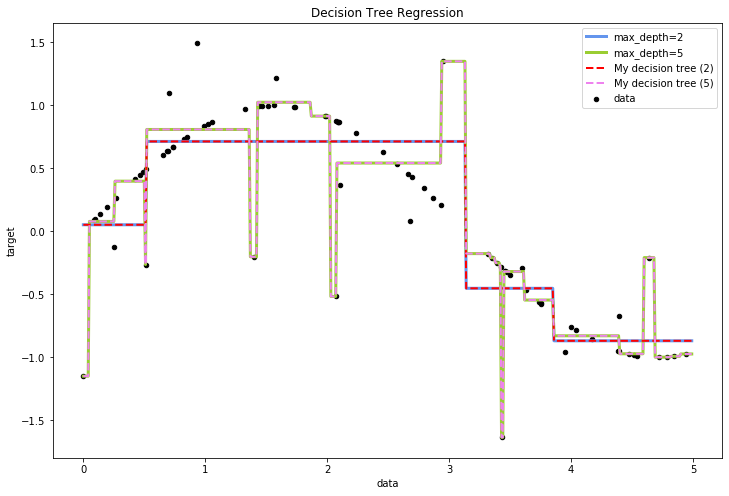

In [6]:
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]

y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)
y_3 = regr_3.predict(X_test)
y_4 = regr_4.predict(X_test)


plt.figure(figsize=(12,8))
plt.scatter(X, y, s=20, c="black", label="data")

plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=3)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=3)
plt.plot(X_test, y_3, color="red", label="My decision tree (2)", linewidth=2, linestyle='dashed')

plt.plot(X_test, y_4, color="violet", label="My decision tree (5)", linewidth=2, linestyle='dashed')
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

#### Gradient boosting

$$r_{i} = -\frac{\partial L(y_i, h(x_i))}{\partial h(x_i)} = -\frac{\partial exp(-y_i h(x_i)}{\partial h(x)} = exp(-y_i h(x_i) y_i = L(y_i, h(x_i))*y_i$$

$$\frac{\partial^2 L(y_i, h(x_i))}{\partial h(x_i)^2} = \frac{\partial^2 exp(-y_i h(x_i)}{\partial h(x)^2}$$

In [7]:
class GradientBoosting:
    def __init__(self, n_trees, depth, lr):
        self.n_trees = n_trees
        self.depth = depth
        self.lr = lr
        
    def compute_grad(self, x, y):
        return self._compute_loss_vector(x, y) * y
    
    def _compute_loss_vector(self, x, y):
        preds = self.predict(x)
        return np.exp(-y*preds)
    
    def compute_loss(self, x, y):
        return np.mean(self._compute_loss_vector(x, y))
    
    def fit_last_tree(self, x, y):
        history = []
        last_tree_preds = self.trees[-1].predict(x)
        
        all_wo_last_preds = np.zeros(len(x))
        all_wo_last_preds += self.constant
        
        for tree in self.trees[:-1]:
            all_wo_last_preds += self.lr*tree.predict(x)

        self.trees[-1].update_terminal_regions(x, y, all_wo_last_preds)
            
        return history
        
    def fit(self, x, y, eval_X, eval_y):
        self.trees = []
        self.constant = np.mean(y)
        
        t = trange(self.n_trees)
        for tree_idx in t:
            to_predict = self.compute_grad(x, y)
            
            tree = Tree(depth=self.depth)
            tree.fit(x, to_predict)
                    
            tree.update_terminal_regions(x, y, self.predict(x))

            self.trees.append(tree)
            
            t.set_description(f'{self.compute_loss(x, y):.2f} / {self.compute_loss(eval_X, eval_y):.2f}')
            
            
    def predict(self, x):
        y_hat = np.zeros(len(x))
        
        y_hat += self.constant
        
        for tree in self.trees:
            y_hat += self.lr*tree.predict(x)
            
        return y_hat
    
    def predict_proba(self, x):
        exp = np.exp(-self.predict(x))
        return 1/(1+exp)

In [8]:
gb = GradientBoosting(50, 2, 0.1)

In [9]:
x = np.linspace(0,10, 50).reshape([50, 1])
y = (np.sin(x)[:,0]+1)/2

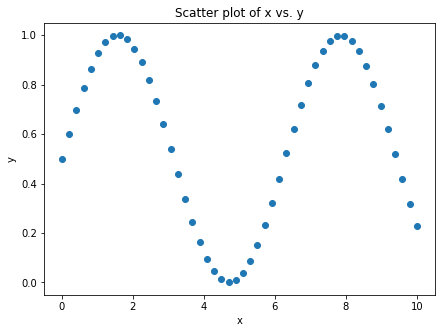

In [10]:
plt.figure(figsize=(7,5))
plt.plot(x,y, 'o')
plt.title("Scatter plot of x vs. y")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [11]:
gb.fit(x, y, x, y)

In [12]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

X, y = make_moons(noise=0.3, random_state=0)
y = 2*y-1

In [13]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.4, random_state=42)

h = .02

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

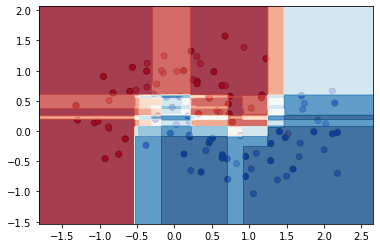

In [14]:
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot(111)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
           edgecolors='k')
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
           edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())

clf = GradientBoosting(50, 3, 0.1)
clf.fit(X_train, y_train, X_test, y_test)

Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])

Z = (Z.reshape(xx.shape)+1)/2
ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

#### Тестирование градиентного бустинга

In [15]:
test = np.loadtxt('spam.test.txt')
train = np.loadtxt('spam.train.txt')

In [16]:
y_train = train[:, 0]
X_train = train[:, 1:]

y_test = test[:, 0]
X_test = test[:, 1:]

y_train -= 0.5
y_train *= 2

y_test -= 0.5
y_test *= 2

In [17]:
clf = GradientBoosting(300, 3, 0.1)
clf.fit(X_train, y_train, eval_X = X_test, eval_y = y_test)

In [33]:
from sklearn.ensemble import GradientBoostingClassifier

losses = {
    'train_sk':[],
    'train':[],
    'test_sk':[],
    'test':[]
}

trees_list = np.arange(10, 301, 10)

for n_trees in tqdm(trees_list):
    sk_clf = GradientBoostingClassifier(loss='exponential', learning_rate= 0.1, 
                                    n_estimators=n_trees, max_depth=3, init='zero',
                                    criterion='mse')
    sk_clf.fit(X_train, y_train)
    
    clf_preds_test = np.zeros(len(X_test))
    clf_preds_test += clf.constant
    for tree in clf.trees[:n_trees]:
        clf_preds_test += tree.predict(X_test)*clf.lr

    clf_preds_train = np.zeros(len(X_train))
    clf_preds_train += clf.constant
    for tree in clf.trees[:n_trees]:
        clf_preds_train += tree.predict(X_train)*clf.lr


    losses['test'].append(np.mean(np.exp(-y_test*clf_preds_test)))
    losses['test_sk'].append(np.mean(np.exp(-y_test*sk_clf.decision_function(X_test))))
    
    losses['train'].append(np.mean(np.exp(-y_train*clf_preds_train)))
    losses['train_sk'].append(np.mean(np.exp(-y_train*sk_clf.decision_function(X_train))))

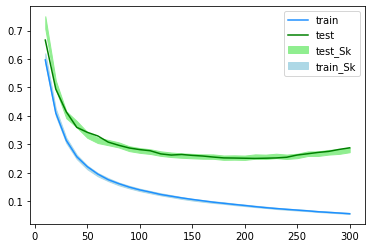

In [34]:
plt.plot(trees_list, losses['train'], color='dodgerblue', label='train')

plt.plot(trees_list, losses['test'], color='green', label='test')

plt.fill_between(trees_list,
                 np.array(losses['test_sk'])*0.97,
                 np.array(losses['test_sk'])*1.03, color='lightgreen', label='test_Sk')

plt.fill_between(trees_list,
                 np.array(losses['train_sk'])*0.97,
                 np.array(losses['train_sk'])*1.03, color='lightblue', label='train_Sk')
plt.legend()

Text(0, 0.5, 'Mine')

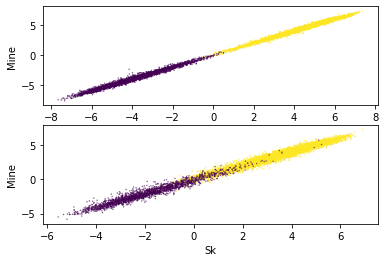

In [35]:
plt.subplot(211)
plt.scatter(sk_clf.decision_function(X_train), clf.predict(X_train), s=0.1, c=y_train)
plt.xlabel('Sk')
plt.ylabel('Mine')

plt.subplot(212)
plt.scatter(sk_clf.decision_function(X_test), clf.predict(X_test), s=0.1, c=y_test)
plt.xlabel('Sk')
plt.ylabel('Mine')

#### Извлечение признаков и логистическая регрессия

In [77]:
def enumerate_tree(tree, offset = 0):
    if tree.depth==0:
        tree.id = offset
        return offset+1
    
    else:
        offset_left = enumerate_tree(tree.left, offset)
        offset_right = enumerate_tree(tree.right, offset_left)
        
        return offset_right

In [78]:
class FeatureExtractor:
    def __init__(self, model):
        self.model = model
        self.tree_offsets = [enumerate_tree(tree) for tree in model.trees]
        self.feature_vector_size = sum(self.tree_offsets)
        
    def predict(self, x):
        output = np.zeros((len(x), self.feature_vector_size))
        
        cum_offset = 0
        for tree, tree_offset in zip(self.model.trees, self.tree_offsets):
            predictions = tree.predict(x, get_id = True)
            output[np.arange(len(output)), (predictions+cum_offset).astype(int)] = 1
            
            cum_offset += tree_offset
        
        return output

In [79]:
fe = FeatureExtractor(clf)

In [80]:
X_train_transformed = fe.predict(X_train)
X_test_transformed = fe.predict(X_test)

In [81]:
def sigmoid(x):
    sigm_value_x = 1 / (1 + np.exp(-x))
    return sigm_value_x

def batch_generator(X, y, shuffle=True, batch_size=1):
    n = X.shape[0]
    assert n == y.shape[0]
    
    indicies = np.arange(len(X))

    if shuffle:
        np.random.shuffle(indicies)
        
    for i in range(0,n,batch_size):
        X_batch = X[indicies[i:min(n,i+batch_size)]]
        y_batch = y[indicies[i:min(n,i+batch_size)]]
        yield (X_batch, y_batch)

class LinearRegression:

    def __init__(self, batch_generator, C=1, alpha=0.01, max_epoch=10, batch_size=10):
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter': [], 'loss': []}
        self.batch_size = batch_size

    def calc_loss(self, X_batch, y_batch):
        predicted = self.predict(X_batch)
        
        a = sigmoid(np.dot(X_batch, self.weights))

        loss = -(1 / X_batch.shape[0]) * \
            np.sum(y_batch * np.log2(a) +
                   (1 - y_batch) * np.log2(1 - a))

        R = np.linalg.norm(self.weights) / self.C
        return loss + R

    def calc_loss_grad(self, X_batch, y_batch):
        N = X_batch.shape[0]

        a = sigmoid(np.dot(X_batch, self.weights))
        loss_grad = (1 / N) * np.dot((a - y_batch), X_batch) + \
                    (2 / self.C) * self.weights

        return loss_grad

    def update_weights(self, new_grad):
        self.weights -= self.alpha * new_grad

    def fit(self, X, y):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        self.weights = np.random.uniform(0, 1, X.shape[1])

        for n in trange(0, self.max_epoch):
            new_epoch_generator = \
                self.batch_generator(X, y,
                                     shuffle=True, batch_size=self.batch_size)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)
                batch_loss = self.calc_loss(X_batch, y_batch)

                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)

    def predict(self, X):
        y_hat = np.dot(X, self.weights)
        return (y_hat >= 0.5).astype(int)
    
    def predict_proba(self, X):
        y_hat = np.dot(X, self.weights)
        return y_hat

In [82]:
lr = LinearRegression(batch_generator, C=1, alpha=1e-2, batch_size=200)

In [83]:
lr.fit(X_train_transformed,(y_train+1)/2)

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log2
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in multiply


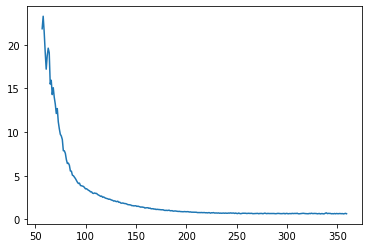

In [84]:
plt.plot(lr.errors_log['loss'])

In [85]:
X_test_transformed = np.hstack((np.ones((X_test_transformed.shape[0], 1)), X_test_transformed))

In [86]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, lr.predict_proba(X_test_transformed))

0.981918744553825

In [87]:
roc_auc_score(y_test, clf.predict(X_test))

0.9868020243570517

In [88]:
roc_auc_score(y_test, sk_clf.predict_proba(X_test)[:,1])

0.9860723832655487